Create a convolutional neural network to classify images

In [47]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix as cf_mtx
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tensorflow.keras import layers, models

In [54]:
# Create a convolutional neural network
def create_convnet(input_shape, n_classes, dense_neurons=128, dropout=0.5):

    # Create a convolutional base, with a stack of convolutional and maxpool layers
    model = models.Sequential([
        layers.Conv2D(filters=32, kernel_size=5, activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D(padding='same'),
        layers.Conv2D(filters=64, kernel_size=3, activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(padding='same'),
        layers.Conv2D(filters=64, kernel_size=3, activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(padding='same'),
        layers.Flatten(),
        layers.Dense(dense_neurons, activation='relu'),
        layers.Dropout(dropout),
        layers.Dense(dense_neurons, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)),
        layers.Dropout(dropout),
        layers.Dense(n_classes, activation='softmax'),
    ])

    return model

# Get class weights to handle imbalance
def get_class_weights(y, verbose=False):
    
    counts = np.unique(y, return_counts=True)
    weights = (np.sum(counts[1]) / counts[1]) / len(counts[0])
    
    if verbose == True:
        print('Class weights:', dict(zip(counts[0], weights)))

    return dict(zip(counts[0], weights))

# Training loop
def train_model(model, Xtrain, ytrain, Xval, yval,
    learning_rate, epochs, batch_size, loss, metrics,
    model_savedir, use_weights=False):

    # Create a callback to save model weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath='{}/model_weights/cp.ckpt'.format(model_savedir),
        save_weights_only=True, verbose=1)

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=loss, metrics=metrics)

    # If use_weights flag is true, calculate class weights and used them in training
    if use_weights == True:
        # Get class weights
        class_weights = get_class_weights(ytrain, verbose=True)

        # Train the model
        history = model.fit(Xtrain, ytrain, validation_data=(Xval, yval),
            epochs=epochs, batch_size=batch_size, callbacks=[cp_callback],
            class_weight=class_weights)
    else:
        # Train the model
        history = model.fit(Xtrain, y_train, validation_data=(Xval, yval),
            epochs=epochs, batch_size=batch_size, callbacks=[cp_callback])

    # Save trained model and weights
    model.save(os.path.join('{}/trained_model.h5'.format(model_savedir)))
    
    return model, history

# Plot training history
def plot_history(history, epochs):

    x = np.arange(epochs, dtype=int) + 1
    plt.plot(x, history.history['loss'], label='Training loss')
    plt.plot(x, history.history['val_loss'], label='Validation loss')
    plt.legend(frameon=False)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')

# Plot a confusion matrix
def confusion_matrix(y_pred, y_true, labels, normalize=True, size=(8,8), title=None):

    cm_abs = cf_mtx(y_true, np.argmax(y_pred, axis=1))

    if normalize == True:
        cm = cm_abs.astype('float') / cm_abs.sum(axis=1, keepdims=True)
    
    # Define colourmap for plot
    cmap = plt.cm.Oranges

    fig, ax = plt.subplots(figsize=size)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)

    # Create an axis to the right of ax. Width of cax will be 5% of ax and the
    # padding between cax and ax will be fixed at 0.05 in
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2)

    ax.figure.colorbar(im, cax=cax)
    ax.set_aspect('equal')
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        # ... and label them with the respective list entries
        xticklabels=labels, yticklabels=labels,
        ylabel='True label',
        xlabel='Predicted label')

    # Set the tick labels font
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(20)

    ax.set_title(title)
    ax.tick_params(axis='y', pad=10)
    ax.set_ylim(len(cm)-0.5, -0.5)    # Needed to fix a bug that cuts the plot

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), ha="right", rotation=0,
            rotation_mode="anchor")
    im.set_clim(0,1)
    #plt.setp(ax.get_yticklabels(), ha="center",
            #rotation=90, rotation_mode='anchor')

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' #if normalize else 'd'
    abs_fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black", fontsize=16)
            ax.text(j, i+0.15, '({})'.format(cm_abs[i, j], abs_fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black", fontsize=14)
            
    plt.tight_layout()

    return plt

In [9]:
# Load data
X_train = np.load('X_train.npy', allow_pickle=True)
y_train = np.load('y_train.npy', allow_pickle=True)
X_val = np.load('X_val.npy', allow_pickle=True)
y_val = np.load('y_val.npy', allow_pickle=True)
X_test = np.load('X_test.npy', allow_pickle=True)
y_test = np.load('y_test.npy', allow_pickle=True)

In [10]:
print(X_train.shape)

(3796, 25, 120)


In [35]:
n_classes = 3
dense_neurons = 100
input_shape = (25, 120, 1) # rows, columns, channels

# Create CNN model
cnn_model = create_convnet(input_shape=input_shape, n_classes=n_classes)

# Set save directories
model_savedir = 'trained_model'
try:
    os.makedirs(model_savedir)
except FileExistsError:
    pass

# Set hyperparameters
epochs = 10
learning_rate = 1e-4
batch_size = 64
metrics = ['accuracy']
# Define loss function
loss=tf.losses.SparseCategoricalCrossentropy()

cnn_model, history = train_model(cnn_model, X_train, y_train, X_val, y_val,
                                 learning_rate=learning_rate, epochs=epochs,
                                 batch_size=batch_size, loss=loss,
                                 metrics=metrics, model_savedir=model_savedir,
                                 use_weights=True)

Class weights: {0: 0.5898989898989899, 1: 14.378787878787877, 2: 0.8095542759650245}
Epoch 1/10
59/60 [============================>.] - ETA: 0s - loss: 2.5748 - accuracy: 0.4936
Epoch 1: saving model to trained_model/model_weights/cp.ckpt
60/60 [==============================] - 5s 84ms/step - loss: 2.5739 - accuracy: 0.4942 - val_loss: 2.4782 - val_accuracy: 0.0252
Epoch 2/10
59/60 [============================>.] - ETA: 0s - loss: 2.2678 - accuracy: 0.5826
Epoch 2: saving model to trained_model/model_weights/cp.ckpt
60/60 [==============================] - 5s 79ms/step - loss: 2.2667 - accuracy: 0.5825 - val_loss: 2.5624 - val_accuracy: 0.0252
Epoch 3/10
59/60 [============================>.] - ETA: 0s - loss: 2.2445 - accuracy: 0.5900
Epoch 3: saving model to trained_model/model_weights/cp.ckpt
60/60 [==============================] - 5s 79ms/step - loss: 2.2410 - accuracy: 0.5909 - val_loss: 2.6221 - val_accuracy: 0.0252
Epoch 4/10
59/60 [============================>.] - ETA: 0s 

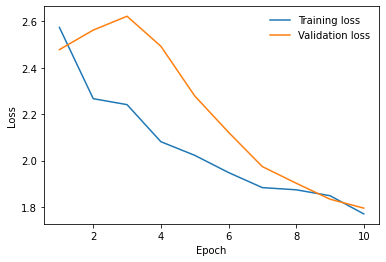

In [40]:
# Plot training history
plot_history(history, epochs)

2/2 [==============================] - 0s 141ms/step


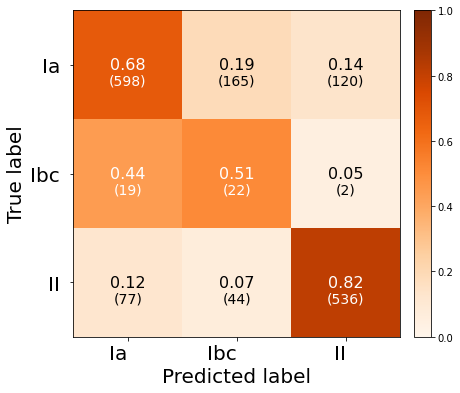

In [57]:
# Plot a confusion matrix
y_pred = cnn_model.predict(X_test, batch_size=1000)

labels = ['Ia', 'Ibc', 'II']
confusion_matrix(y_pred, y_test, labels, size=(6.5, 6.5))
plt.show()